In [1]:
import pandas as pd
import numpy as np
from pydataset import data
import os
import env
import acquire as a
import prepare as p
import wrangle as w
from sklearn.model_selection import train_test_split

#Stats imports
from scipy import stats
from scipy.stats import pearsonr, spearmanr, ttest_1samp, ttest_ind, chi2_contingency


#visual imports
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Scalers
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

# Acquire Data

In [2]:
sql_url = a.get_connection('zillow')

In [3]:
test = '%'
query = f'''
    select * 
    from properties_2017
    left join predictions_2017 using(id)
    left join airconditioningtype as ac on ac.`airconditioningtypeid` = properties_2017.`airconditioningtypeid`
    left join `architecturalstyletype` as ar on ar.`architecturalstyletypeid` = properties_2017.`architecturalstyletypeid`
    left join `buildingclasstype` as b on b.`buildingclasstypeid` = `properties_2017`.`buildingclasstypeid`
    left join `heatingorsystemtype` as h on h.`heatingorsystemtypeid` = properties_2017.`heatingorsystemtypeid`
    left join `propertylandusetype` as p on p.`propertylandusetypeid` = properties_2017.`propertylandusetypeid`
    left join `storytype` as s on s.`storytypeid` = `properties_2017`.`storytypeid`
    left join `typeconstructiontype` as t on t.`typeconstructiontypeid` = `properties_2017`.`typeconstructiontypeid`
    where `transactiondate` like "2017{test}{test}" 

        '''

In [4]:
df = pd.read_sql(query, sql_url)

In [5]:
df.head()

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,buildingclasstypeid,buildingclassdesc,heatingorsystemtypeid,heatingorsystemdesc,propertylandusetypeid,propertylandusedesc,storytypeid,storydesc,typeconstructiontypeid,typeconstructiondesc
0,0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,...,NaN,None,NaN,None,269,Planned Unit Development,NaN,None,NaN,None
1,1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,...,NaN,None,NaN,None,261,Single Family Residential,NaN,None,NaN,None
2,2,10843547,NaN,NaN,NaN,0.0,0.0,5.0,NaN,NaN,...,5.0,Specialized buildings that do not fit in any of the above categories,NaN,None,47,Store/Office (Mixed Use),NaN,None,NaN,None
3,3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,6.0,NaN,...,3.0,"Buildings having exterior walls built of a non-combustible material such as brick, con...",NaN,None,47,Store/Office (Mixed Use),NaN,None,NaN,None
4,4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,...,4.0,Buildings having wood or wood and steel frames,NaN,None,31,Commercial/Office/Residential Mixed Used,NaN,None,NaN,None


In [6]:
def get_zillow_cluster():
    filename = "zillow_cluster.csv"

    if os.path.isfile(filename):
        return pd.read_csv(filename)
    else:
        # read the SQL query into a dataframe
        df = pd.read_sql( query , get_connection('zillow'))

        # Write that dataframe to disk for later. Called "caching" the data for later.
        df.to_csv(filename, index=False)

        # Return the dataframe
        return df  

In [7]:
df.shape

(77613, 76)

In [8]:
# no dupes seen
df.duplicated().value_counts()

False    77613
dtype: int64

In [9]:
df = df.drop_duplicates()

# Summarize your data (summary stats, info, dtypes, shape, distributions, value_counts, etc.)



In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,77613.0,3.880600e+04,2.240509e+04,0.000000e+00,1.940300e+04,3.880600e+04,5.820900e+04,7.761200e+04
parcelid,77613.0,1.337946e+07,8.351498e+06,1.071174e+07,1.158574e+07,1.253226e+07,1.411511e+07,1.696019e+08
airconditioningtypeid,21456.0,1.927246e+00,3.132984e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.300000e+01
architecturalstyletypeid,151.0,7.430464e+00,2.629347e+00,2.000000e+00,7.000000e+00,7.000000e+00,7.000000e+00,2.100000e+01
basementsqft,45.0,5.931333e+02,4.609169e+02,6.300000e+01,2.200000e+02,5.400000e+02,7.320000e+02,2.443000e+03
bathroomcnt,77613.0,2.214616e+00,1.083469e+00,0.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,2.000000e+01
bedroomcnt,77613.0,3.083981e+00,1.275549e+00,0.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,2.500000e+01
buildingclasstypeid,383.0,3.775457e+00,4.595960e-01,1.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,5.000000e+00
buildingqualitytypeid,50321.0,6.300491e+00,1.725771e+00,1.000000e+00,5.000000e+00,6.000000e+00,8.000000e+00,1.200000e+01
calculatedbathnbr,74390.0,2.309732e+00,1.001987e+00,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,2.000000e+01


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77613 entries, 0 to 77612
Data columns (total 76 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            77613 non-null  int64  
 1   parcelid                      77613 non-null  int64  
 2   airconditioningtypeid         21456 non-null  float64
 3   architecturalstyletypeid      151 non-null    float64
 4   basementsqft                  45 non-null     float64
 5   bathroomcnt                   77613 non-null  float64
 6   bedroomcnt                    77613 non-null  float64
 7   buildingclasstypeid           383 non-null    float64
 8   buildingqualitytypeid         50321 non-null  float64
 9   calculatedbathnbr             74390 non-null  float64
 10  decktypeid                    513 non-null    float64
 11  finishedfloor1squarefeet      5973 non-null   float64
 12  calculatedfinishedsquarefeet  76501 non-null  float64
 13  f

In [12]:
# checking for nulls. a lot of nulls
df.isna().sum()

id                                  0
parcelid                            0
airconditioningtypeid           56157
architecturalstyletypeid        77462
basementsqft                    77568
bathroomcnt                         0
bedroomcnt                          0
buildingclasstypeid             77230
buildingqualitytypeid           27292
calculatedbathnbr                3223
decktypeid                      77100
finishedfloor1squarefeet        71640
calculatedfinishedsquarefeet     1112
finishedsquarefeet12             6650
finishedsquarefeet13            77378
finishedsquarefeet15            72855
finishedsquarefeet50            71640
finishedsquarefeet6             77068
fips                                0
fireplacecnt                    69201
fullbathcnt                      3223
garagecarcnt                    54313
garagetotalsqft                 54313
hashottuborspa                  76355
heatingorsystemtypeid           29139
latitude                            0
longitude   

In [13]:
df.latitude.isna().sum()

0

In [14]:
df.longitude.isna().sum()

0

(0.0, 1500000.0)

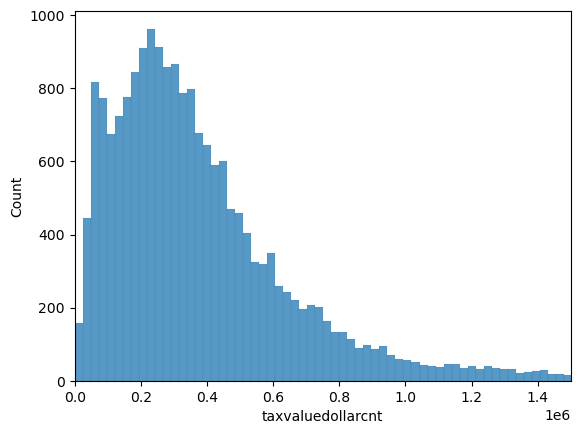

In [15]:
# Histogram. Right-skewed
sns.histplot(df.taxvaluedollarcnt.sample(20000))
plt.xlim(0, 1500000)

In [16]:
# Types of A/C units
df.airconditioningdesc.value_counts()

Central          19626
Yes               1509
None               219
Refrigeration       55
Wall Unit           46
Window Unit          1
Name: airconditioningdesc, dtype: int64

In [17]:
# Interesting. Most homes do not list a A/C type
df.airconditioningdesc.isna().sum()

56157

# Write a function that takes in a dataframe of observations and attributes and returns a dataframe where each row is an atttribute name, the first column is the number of rows with missing values for that attribute, and the second column is percent of total rows that have missing values for that attribute. Run the function and document takeaways from this on how you want to handle missing values.

In [18]:
# all column names in a list
cols_name = df.columns.tolist()
cols_name[:5]

['id',
 'parcelid',
 'airconditioningtypeid',
 'architecturalstyletypeid',
 'basementsqft']

In [19]:
for col in cols_name:
    
    df[col].isna().sum()

In [20]:
df2 = df.loc[:,~df.columns.duplicated()]

In [21]:
df2.head()

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,...,NaN,0.025595,2017-01-01,None,None,None,None,Planned Unit Development,None,None
1,1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,...,NaN,0.055619,2017-01-01,None,None,None,None,Single Family Residential,None,None
2,2,10843547,NaN,NaN,NaN,0.0,0.0,5.0,NaN,NaN,...,NaN,0.005383,2017-01-01,None,None,Specialized buildings that do not fit in any of the above categories,None,Store/Office (Mixed Use),None,None
3,3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,6.0,NaN,...,NaN,-0.103410,2017-01-01,None,None,"Buildings having exterior walls built of a non-combustible material such as brick, con...",None,Store/Office (Mixed Use),None,None
4,4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,...,NaN,0.006940,2017-01-01,None,None,Buildings having wood or wood and steel frames,None,Commercial/Office/Residential Mixed Used,None,None


### Drop id columns

In [22]:
df.drop(['parcelid'], axis=1, inplace=True)

In [23]:
df.columns.duplicated()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False,  True,
       False,  True, False,  True, False,  True, False,  True, False,
        True, False])

In [24]:
df.typeconstructiontypeid.head(3)

,typeconstructiontypeid,typeconstructiontypeid
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN


In [25]:
df.storytypeid.head(3)

,storytypeid,storytypeid
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN


In [26]:
df.buildingclasstypeid.head(3)

,buildingclasstypeid,buildingclasstypeid
0,NaN,NaN
1,NaN,NaN
2,5.0,5.0


In [27]:
df.drop(['typeconstructiontypeid','storytypeid','buildingclasstypeid'], axis=1, inplace=True)

In [28]:
df.columns.duplicated()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False,  True, False, False,  True,
       False,  True, False, False, False])

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77613 entries, 0 to 77612
Data columns (total 68 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            77613 non-null  int64  
 1   airconditioningtypeid         21456 non-null  float64
 2   architecturalstyletypeid      151 non-null    float64
 3   basementsqft                  45 non-null     float64
 4   bathroomcnt                   77613 non-null  float64
 5   bedroomcnt                    77613 non-null  float64
 6   buildingqualitytypeid         50321 non-null  float64
 7   calculatedbathnbr             74390 non-null  float64
 8   decktypeid                    513 non-null    float64
 9   finishedfloor1squarefeet      5973 non-null   float64
 10  calculatedfinishedsquarefeet  76501 non-null  float64
 11  finishedsquarefeet12          70963 non-null  float64
 12  finishedsquarefeet13          235 non-null    float64
 13  f

**Drop these also**

propertylandusetypeid

heatingorsystemtypeid

architecturalstyletypeid

airconditioningtypeid

In [30]:
df[['propertylandusetypeid','heatingorsystemtypeid','architecturalstyletypeid','airconditioningtypeid']].head()

,propertylandusetypeid,propertylandusetypeid,heatingorsystemtypeid,heatingorsystemtypeid,architecturalstyletypeid,architecturalstyletypeid,airconditioningtypeid,airconditioningtypeid
0,269.0,269,NaN,NaN,NaN,NaN,NaN,NaN
1,261.0,261,NaN,NaN,NaN,NaN,NaN,NaN
2,47.0,47,NaN,NaN,NaN,NaN,NaN,NaN
3,47.0,47,NaN,NaN,NaN,NaN,NaN,NaN
4,31.0,31,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
df.drop(['propertylandusetypeid','heatingorsystemtypeid','architecturalstyletypeid','airconditioningtypeid'], axis=1, inplace=True)


In [32]:
df.columns.duplicated().sum()

0

In [33]:
df.head()

,id,basementsqft,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.025595,2017-01-01,None,None,None,None,Planned Unit Development,None,None
1,1,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.055619,2017-01-01,None,None,None,None,Single Family Residential,None,None
2,2,NaN,0.0,0.0,NaN,NaN,NaN,NaN,73026.0,NaN,...,NaN,0.005383,2017-01-01,None,None,Specialized buildings that do not fit in any of the above categories,None,Store/Office (Mixed Use),None,None
3,3,NaN,0.0,0.0,6.0,NaN,NaN,NaN,5068.0,NaN,...,NaN,-0.103410,2017-01-01,None,None,"Buildings having exterior walls built of a non-combustible material such as brick, con...",None,Store/Office (Mixed Use),None,None
4,4,NaN,0.0,0.0,NaN,NaN,NaN,NaN,1776.0,NaN,...,NaN,0.006940,2017-01-01,None,None,Buildings having wood or wood and steel frames,None,Commercial/Office/Residential Mixed Used,None,None


In [34]:
df.isna().sum()

id                                  0
basementsqft                    77568
bathroomcnt                         0
bedroomcnt                          0
buildingqualitytypeid           27292
calculatedbathnbr                3223
decktypeid                      77100
finishedfloor1squarefeet        71640
calculatedfinishedsquarefeet     1112
finishedsquarefeet12             6650
finishedsquarefeet13            77378
finishedsquarefeet15            72855
finishedsquarefeet50            71640
finishedsquarefeet6             77068
fips                                0
fireplacecnt                    69201
fullbathcnt                      3223
garagecarcnt                    54313
garagetotalsqft                 54313
hashottuborspa                  76355
latitude                            0
longitude                           0
lotsizesquarefeet                7079
poolcnt                         63352
poolsizesum                     76836
pooltypeid10                    77189
pooltypeid2 

In [35]:
df2 = pd.DataFrame(df.isna().sum())

In [36]:
df2.rename(columns={0: 'num_rows_missing'}, inplace=True)

In [37]:
df2['pct_rows_missing'] = df2['num_rows_missing'] / len(df)

In [38]:
df2.head()

,num_rows_missing,pct_rows_missing
id,0,0.000000
basementsqft,77568,0.999420
bathroomcnt,0,0.000000
bedroomcnt,0,0.000000
buildingqualitytypeid,27292,0.351642


### Missing Function()

In [39]:
def missing(df):
    
    # Create df of sum of nulls
    df2 = pd.DataFrame(df.isna().sum())
    
    # Rename column
    df2.rename(columns={0: 'num_rows_missing'}, inplace=True)
    
    # Create new row using value of rows missing / length of OG df
    df2['pct_rows_missing'] = df2['num_rows_missing'] / len(df)
    
    return df2

In [40]:
df2.head()

,num_rows_missing,pct_rows_missing
id,0,0.000000
basementsqft,77568,0.999420
bathroomcnt,0,0.000000
bedroomcnt,0,0.000000
buildingqualitytypeid,27292,0.351642


# Zillow Prepare

## Remove any properties that are likely to be something other than single unit properties. (e.g. no duplexes, no land/lot, ...). There are multiple ways to estimate that a property is a single unit, and there is not a single "right" answer.



In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77613 entries, 0 to 77612
Data columns (total 60 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            77613 non-null  int64  
 1   basementsqft                  45 non-null     float64
 2   bathroomcnt                   77613 non-null  float64
 3   bedroomcnt                    77613 non-null  float64
 4   buildingqualitytypeid         50321 non-null  float64
 5   calculatedbathnbr             74390 non-null  float64
 6   decktypeid                    513 non-null    float64
 7   finishedfloor1squarefeet      5973 non-null   float64
 8   calculatedfinishedsquarefeet  76501 non-null  float64
 9   finishedsquarefeet12          70963 non-null  float64
 10  finishedsquarefeet13          235 non-null    float64
 11  finishedsquarefeet15          4758 non-null   float64
 12  finishedsquarefeet50          5973 non-null   float64
 13  f

In [42]:
df[['propertylandusedesc','buildingclassdesc', 'storydesc','typeconstructiondesc','numberofstories']].head()

,propertylandusedesc,buildingclassdesc,storydesc,typeconstructiondesc,numberofstories
0,Planned Unit Development,None,None,None,NaN
1,Single Family Residential,None,None,None,NaN
2,Store/Office (Mixed Use),Specialized buildings that do not fit in any of the above categories,None,None,1.0
3,Store/Office (Mixed Use),"Buildings having exterior walls built of a non-combustible material such as brick, con...",None,None,1.0
4,Commercial/Office/Residential Mixed Used,Buildings having wood or wood and steel frames,None,None,1.0


In [43]:
# Value counts. 
df.propertylandusedesc.value_counts()

Single Family Residential                     56079
Condominium                                   12491
Duplex (2 Units, Any Combination)              2852
Mobile Home                                    1681
Planned Unit Development                       1609
Triplex (3 Units, Any Combination)             1021
Quadruplex (4 Units, Any Combination)           980
Cluster Home                                    288
Commercial/Office/Residential Mixed Used        272
Store/Office (Mixed Use)                        144
Residential General                             103
Cooperative                                      48
Manufactured, Modular, Prefabricated Homes       35
Townhouse                                         9
Residential Common Area                           1
Name: propertylandusedesc, dtype: int64

Takeaways:
- propertylandusedesc filter for: Single Family Residential,Mobile Home

In [44]:
# Filtering for single unit properties
su_buildings = df[(df['propertylandusedesc'] == 'Single Family Residential') | \
   (df['propertylandusedesc'] == 'Mobile Home') ]


## Create a function that will drop rows or columns based on the percent of values that are missing: handle_missing_values(df, prop_required_column, prop_required_row).

In [45]:
df.basementsqft.isna().sum() / len(df)

0.9994202002241892

In [46]:
df.dropna(thresh= round(len(df) * .9), axis=1)

    

,id,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,latitude,longitude,...,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,propertylandusedesc
0,0,0.0,0.0,NaN,NaN,NaN,6037.0,NaN,34144442.0,-118654084.0,...,NaN,NaN,9.0,2016.0,9.0,NaN,NaN,0.025595,2017-01-01,Planned Unit Development
1,1,0.0,0.0,NaN,NaN,NaN,6037.0,NaN,34140430.0,-118625364.0,...,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,0.055619,2017-01-01,Single Family Residential
2,2,0.0,0.0,NaN,73026.0,NaN,6037.0,NaN,33989359.0,-118394633.0,...,1959.0,660680.0,1434941.0,2016.0,774261.0,20800.37,NaN,0.005383,2017-01-01,Store/Office (Mixed Use)
3,3,0.0,0.0,NaN,5068.0,NaN,6037.0,NaN,34148863.0,-118437206.0,...,1948.0,580059.0,1174475.0,2016.0,594416.0,14557.57,NaN,-0.103410,2017-01-01,Store/Office (Mixed Use)
4,4,0.0,0.0,NaN,1776.0,NaN,6037.0,NaN,34194168.0,-118385816.0,...,1947.0,196751.0,440101.0,2016.0,243350.0,5725.17,NaN,0.006940,2017-01-01,Commercial/Office/Residential Mixed Used
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77608,77608,2.0,3.0,2.0,1600.0,1600.0,6037.0,2.0,34564162.0,-118030512.0,...,1992.0,137951.0,180715.0,2016.0,42764.0,3677.13,6.037911e+13,-0.002245,2017-09-20,Single Family Residential
77609,77609,3.0,4.0,3.0,1921.0,1921.0,6037.0,3.0,34572256.0,-118024872.0,...,1990.0,129566.0,162019.0,2016.0,32453.0,2860.33,6.037911e+13,0.020615,2017-09-20,Single Family Residential
77610,77610,3.0,4.0,3.0,1780.0,1780.0,6037.0,3.0,34571498.0,-118039412.0,...,1989.0,100744.0,125923.0,2016.0,25179.0,2394.26,6.037911e+13,0.013209,2017-09-21,Single Family Residential
77611,77611,2.0,3.0,2.0,1549.0,1549.0,6037.0,2.0,34575327.0,-118054267.0,...,1990.0,149241.0,198988.0,2016.0,49747.0,3331.81,6.037911e+13,0.037129,2017-09-21,Single Family Residential


In [47]:
round(len(df) * .9)

69852

In [48]:
df.basementsqft.isna().sum() / len(df)

0.9994202002241892

In [49]:
def handle_missing_values(df, prop_column_req):
    
    '''
    Function that intakes df and a proportion of a column that should not be nulls. Anything above that 
    threshold will be dropped. 
    
    prop_column_req = value between 0 and 1
    '''
    above_pct = round(len(df) * prop_column_req)
    
    ab = df.copy()
    
    ab = ab.dropna(thresh= above_pct, axis=1)
    
    return ab
        

# Acquire data from the customers table in the mall_customers database.


In [50]:
query2 = '''
    select * 
    from customers 

        '''

### Get Mall ()

In [51]:
def get_mall():
    filename = "mall.csv"

    if os.path.isfile(filename):
        return pd.read_csv(filename)
    else:
        # read the SQL query into a dataframe
        df = pd.read_sql( query , get_connection('mall_customers'))

        # Write that dataframe to disk for later. Called "caching" the data for later.
        df.to_csv(filename, index=False)

        # Return the dataframe
        return df  

In [52]:
url = a.get_connection('mall_customers')

mall = get_mall()

In [53]:
mall = pd.read_sql(query2, url)

# Summarize the data (include distributions and descriptive statistics).


In [54]:
mall.head()

,customer_id,gender,age,annual_income,spending_score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [55]:
mall.describe().T

,count,mean,std,min,25%,50%,75%,max
customer_id,200.0,100.50,57.879185,1.0,50.75,100.5,150.25,200.0
age,200.0,38.85,13.969007,18.0,28.75,36.0,49.00,70.0
annual_income,200.0,60.56,26.264721,15.0,41.50,61.5,78.00,137.0
spending_score,200.0,50.20,25.823522,1.0,34.75,50.0,73.00,99.0


In [56]:
mall.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     200 non-null    int64 
 1   gender          200 non-null    object
 2   age             200 non-null    int64 
 3   annual_income   200 non-null    int64 
 4   spending_score  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


# Detect outliers using IQR.


In [57]:
mall.head(3)

,customer_id,gender,age,annual_income,spending_score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6


In [58]:
def upper_outlier_detector(df, column, k=1.5):
    
    
    q1, q3 = df[column].quantile([0.25, 0.75])
    
    iqr = q3 - q1
    
    upper_bound = q3 + k * iqr
    
    return np.where(df[column] > upper_bound, 1, 0)

In [59]:
def lower_outlier_detector(df, column, k=1.5):
    
    
    q1, q3 = df[column].quantile([0.25, 0.75])
    
    iqr = q3 - q1
    
    lower_bound = q1 - k * iqr
    
    return np.where(df[column] < lower_bound, 1, 0)

In [60]:
def outlier_detector(df, column, k=1.5):
    
    
    q1, q3 = df[column].quantile([0.25, 0.75])
    
    iqr = q3 - q1
    
    upper_bound = q1 - k * iqr
    
    lower_bound = q1 - k * iqr
    
    print(f'{column} Upper bound: {upper_bound}, {column} Lower Bound: {lower_bound}')

In [61]:
outlier_detector(mall, 'age')

age Upper bound: -1.625, age Lower Bound: -1.625


# Split data into train, validate, and test.


In [62]:
mall.drop('customer_id', axis=1, inplace=True)

In [63]:
mall.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   gender          200 non-null    object
 1   age             200 non-null    int64 
 2   annual_income   200 non-null    int64 
 3   spending_score  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 6.4+ KB


In [64]:
train, val, test = p.split_data_continious(mall)

In [65]:
train.shape, val.shape, test.shape

((112, 4), (48, 4), (40, 4))

# Encode categorical columns using a one hot encoder (pd.get_dummies).


In [66]:
train = pd.get_dummies(train, columns=['gender'], drop_first=True)
val = pd.get_dummies(val, columns=['gender'], drop_first=True)
test = pd.get_dummies(test, columns=['gender'], drop_first=True)

In [67]:
train.head(3)

,age,annual_income,spending_score,gender_Male
123,39,69,91,1
76,45,54,53,0
171,28,87,75,1


# Handles missing values.


In [68]:
train.isna().sum()

age               0
annual_income     0
spending_score    0
gender_Male       0
dtype: int64

# Scaling

In [69]:
# The trains
X_train = train.drop(['annual_income'], axis=1)
y_train = mall.annual_income

X_val = val.drop(['annual_income'], axis=1)
y_val = val.annual_income

X_test = test.drop(['annual_income'], axis=1)
y_test = test.annual_income


In [70]:
# Scaler object
mm = MinMaxScaler()

In [74]:
columns_scale = ['age','spending_score']
train[columns_scale] = mm.fit_transform(train[columns_scale])

In [75]:
train.head(3)

,age,annual_income,spending_score,gender_Male
123,0.403846,69,0.957447,1
76,0.519231,54,0.553191,0
171,0.192308,87,0.787234,1
